In [1]:
from pdf_reader import PDFReader
from preprocessor import Preprocessor
from vectorizer import Vectorizer
from visualizer import DocumentVisualizer
from rf_model import RFModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import os
import numpy as np

In [2]:
# Load Word2Vec model
vectorizer = Vectorizer("word2Vec_models/cbow_s1000.txt")

In [3]:
pdf_reader = PDFReader()
preprocessor = Preprocessor()
document_visualizer = DocumentVisualizer()

# Create BoW representation of documents
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
lda = LatentDirichletAllocation(n_components=2, random_state=42)

rf_clf = RFModel()

In [4]:
# Process labeled data

X_texts = []
X_word2vec = []
y = []
train_doc_names = []

for filename in os.listdir('documents/'):
  if filename.endswith('.pdf'):
    train_doc_names.append(filename)
    text = pdf_reader.extract_text(os.path.join('documents', filename))
    processed_text = preprocessor.process(text)
    X_texts.append(' '.join(processed_text))
    vectorized_text = vectorizer.calculate_document_vector(processed_text)
    X_word2vec.append(vectorized_text)

    if filename.startswith("risk"):
      label = 0  # Risk Report
    elif filename.startswith("privacy"):
      label = 1  # Privacy Policy
    y.append(label)

# Transform documents to a matrix of token counts (for LDA)
X_count = count_vectorizer.fit_transform(X_texts)

# Apply LDA for topic analysis
lda.fit(X_count)
doc_topic_dist = lda.transform(X_count)

# Visualize topic words
document_visualizer.print_topic_words(lda, count_vectorizer.get_feature_names_out())

# Combine only Word2Vec features for classification
X_combined = np.array(X_word2vec)

# Train RF model with only Word2Vec features
rf_clf.fit(X_combined, y)

# Hyperparameter Tuning
param_grid = {
  'n_estimators': [100, 200, 300],
  'max_features': ['sqrt', 'log2'],
}
best_params = rf_clf.tune_hyperparameters(X_combined, y, param_grid)
print("\nBest Parameters:", best_params)

# Training with Cross-Validation
rf_clf.fit(X_combined, y)
cv_scores = rf_clf.cross_validate(X_combined, y, cv=5)
print("Cross-validation scores:", cv_scores)

Topic #0: risco 00 capital crédito gerenciamento exposição riscos operação instituição total liquidez financeiro mercado ativo gestão relatório pilar processo tabela organização
Topic #1: segurança risco cibernética acesso controle ser dado processo art negócio serviço incidente gestão procedimento tecnologia garantir responsável trabalho realizar interno

Best Parameters: {'max_features': 'sqrt', 'n_estimators': 100}
Cross-validation scores: [1.         0.83333333 1.         0.8        1.        ]


In [5]:
# Analyze new data

new_X_texts = []
new_X_word2vec = []
analyze_doc_names = []

# Loop through each PDF in the analyze folder
for filename in os.listdir('analyze/'):
  if filename.endswith('.pdf'):
    analyze_doc_names.append(filename)

    # Read and preprocess the text
    new_text = pdf_reader.extract_text(os.path.join('analyze', filename))
    new_processed_text = preprocessor.process(new_text)
    new_X_texts.append(' '.join(new_processed_text))
    new_vectorized_text = vectorizer.calculate_document_vector(new_processed_text)
    new_X_word2vec.append(new_vectorized_text)

# Transform new documents to a matrix of token counts (for LDA)
new_X_count = count_vectorizer.transform(new_X_texts)

# Apply LDA on new data for topic analysis
new_doc_topic_dist = lda.transform(new_X_count)

# Combine only Word2Vec features for new data
new_X_combined = np.array(new_X_word2vec)

# Predicting labels for new data using Random Forest
predictions = rf_clf.predict(new_X_combined)

# Model Evaluation
metrics = rf_clf.evaluate_model(new_X_combined, predictions)
print("Model Evaluation Metrics:", metrics)

# Convert X_word2vec to a NumPy array
X_word2vec_array = np.array(X_word2vec)

# Feature Importance Analysis
word2vec_feature_names = [f"Word2Vec_Feature_{i}" for i in range(X_word2vec_array.shape[1])]
importances = rf_clf.get_feature_importances(word2vec_feature_names)
print(f"Feature Importances: {importances}")

Model Evaluation Metrics: {'Confusion Matrix': array([[4, 0],
       [0, 4]]), 'ROC AUC': 1.0, 'Precision-Recall AUC': 1.0}
Feature Importances: [('Word2Vec_Feature_374', 0.03), ('Word2Vec_Feature_521', 0.03), ('Word2Vec_Feature_731', 0.03), ('Word2Vec_Feature_57', 0.028444444444444446), ('Word2Vec_Feature_300', 0.021414141414141413), ('Word2Vec_Feature_10', 0.021333333333333333), ('Word2Vec_Feature_56', 0.02), ('Word2Vec_Feature_114', 0.02), ('Word2Vec_Feature_129', 0.02), ('Word2Vec_Feature_199', 0.02), ('Word2Vec_Feature_206', 0.02), ('Word2Vec_Feature_291', 0.02), ('Word2Vec_Feature_320', 0.02), ('Word2Vec_Feature_341', 0.02), ('Word2Vec_Feature_399', 0.02), ('Word2Vec_Feature_410', 0.02), ('Word2Vec_Feature_450', 0.02), ('Word2Vec_Feature_801', 0.02), ('Word2Vec_Feature_848', 0.02), ('Word2Vec_Feature_795', 0.018666666666666668), ('Word2Vec_Feature_783', 0.01723970473970474), ('Word2Vec_Feature_40', 0.011333333333333332), ('Word2Vec_Feature_5', 0.01), ('Word2Vec_Feature_12', 0.01)

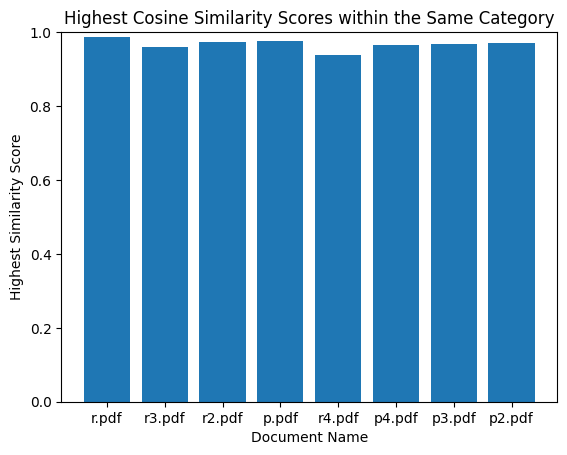

The highest similarity score of r.pdf within its category is: 98.61.
The highest similarity score of r3.pdf within its category is: 95.98.
The highest similarity score of r2.pdf within its category is: 97.33.
The highest similarity score of p.pdf within its category is: 97.50.
The highest similarity score of r4.pdf within its category is: 93.70.
The highest similarity score of p4.pdf within its category is: 96.59.
The highest similarity score of p3.pdf within its category is: 96.83.
The highest similarity score of p2.pdf within its category is: 97.12.


r.pdf: Risk Report
r3.pdf: Risk Report
r2.pdf: Risk Report
p.pdf: Privacy Policy
r4.pdf: Risk Report
p4.pdf: Privacy Policy
p3.pdf: Privacy Policy
p2.pdf: Privacy Policy


Analysis for Document 1:
The new document is most similar to risk14.pdf in terms of topics.
Topic 0: Could be improved. Current weight: 0.58, Reference weight: 0.59
Topic 1: Well covered. Current weight: 0.42, Reference weight: 0.41


Analysis for Document 2:
The new 

In [6]:
# Plot the analyzed data

# Process new data for LDA topic analysis
new_X_count = count_vectorizer.transform(new_X_texts)  # BoW representation for new documents
new_X_topics = lda.transform(new_X_count)  # Topic distribution for new documents


# Calculate and plot the highest similarity scores
highest_scores = document_visualizer.calculate_similarity(new_X_combined, X_combined, y, predictions)
document_visualizer.plot_similarity(highest_scores, analyze_doc_names)

# Print out the highest similarity scores for each document
document_visualizer.print_highest_scores(highest_scores, analyze_doc_names)

print("\n")

# Print out predictions with document names
label_names = ["Risk Report", "Privacy Policy"]

for doc_name, label_index in zip(analyze_doc_names, predictions):
  print(f"{doc_name}: {label_names[label_index]}")

print("\n")

# Compare topics of new data with training data
document_visualizer.compare_topics(new_X_topics, doc_topic_dist, train_doc_names)

# Model Persistence
# Save the model
rf_clf.save_model('rf_model.pkl')

# Load the model (when needed)
# rf_clf.load_model('rf_model.pkl')

print("\nDone!")